In [473]:
import field_trip_helper as fth
import interface as fth_interface
import config as fth_config

import importlib
importlib.reload(fth)
importlib.reload(fth_interface)

<module 'interface' from '/Users/morgan/Documents/GitHub/Field-Trip-Helper/interface.py'>

In [474]:
fth.initialize()

Output()

Output()

In [338]:
import importlib

In [432]:
importlib.reload(fth)

<module 'field_trip_helper' from '/Users/morgan/Documents/GitHub/Field-Trip-Helper/field_trip_helper.py'>

In [436]:
results = fth.search_name(fth_config.data, 'christ')

In [444]:
test = fth.get_name(fth_config.data, 'Christ the King Catholic School - Sterling', date='2024-03-07')
test

[                                          Name             Arrival  \
 16  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 17  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 18  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 19  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 20  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 21  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 22  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 23  Christ the King Catholic School - Sterling 2024-03-07 09:00:00   
 
              Departure                                Program  \
 16 2024-03-07 14:00:00                 Admission - TN Schools   
 17 2024-03-07 14:00:00                 Admission - TN Schools   
 18 2024-03-07 14:00:00                 Admission - TN Schools   
 19 2024-03-07 14:00:00                 Admission - TN Schools   
 20 2024-03-07 14:00:00      

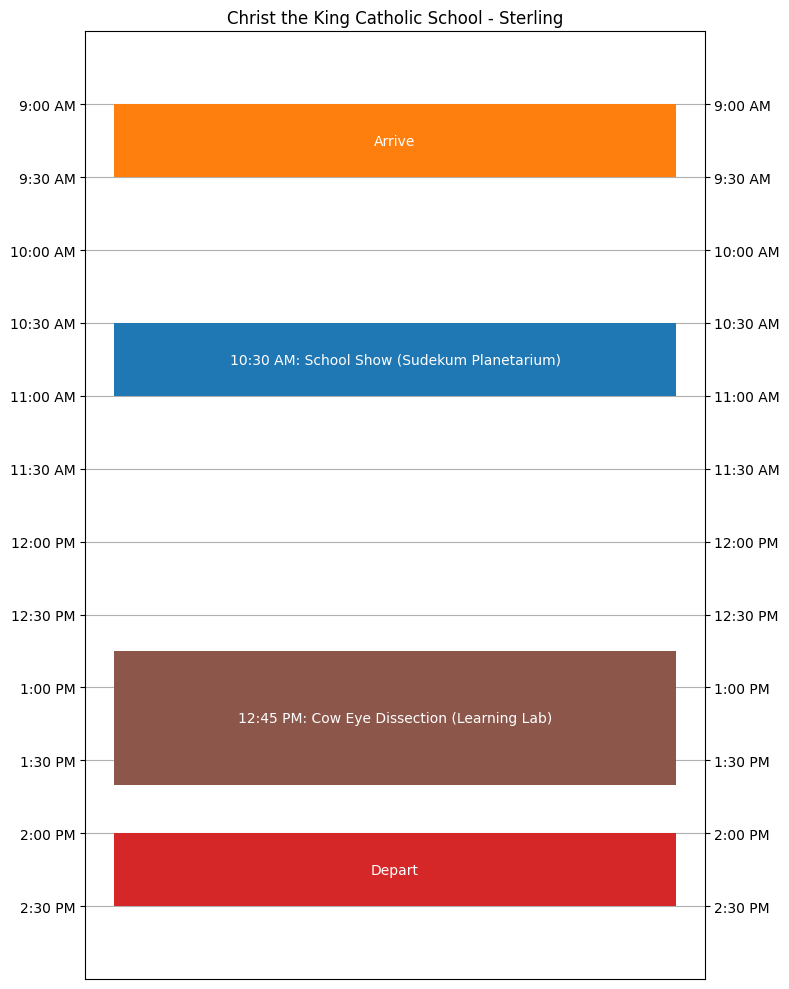

In [467]:
importlib.reload(fth)
fth.create_itinerary_graphic(test[0]);

In [446]:
test[0].groupby(["Name", "Program", "Location", "Start time", "End time", "Capacity"]).sum(
        numeric_only=True).reset_index()

,Name,Program,Location,Start time,End time,Capacity,Quantity
0,Christ the King Catholic School - Sterling,PS - School Shows,Sudekum Planetarium,2024-03-07 10:30:00,2024-03-07 11:00:00,160,35
1,Christ the King Catholic School - Sterling,SCH - L - Cow Eye Dissection STEM Lab,Learning Lab,2024-03-07 12:45:00,2024-03-07 13:40:00,30,23


In [497]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change['new'])

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()